<a href="https://colab.research.google.com/github/mixidota2/kaggle-indoor/blob/main/notebook/Indoor_003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview
- ベースはLSTM
- EXP002で1ずらしでseqlen数のデータを与えていたところを、重複無しで与えるようにする
- あと正しいCVが学習中に見れなくて不便なので99%accのデータを一緒に与えてみれるようにする




In [1]:
!nvidia-smi

Fri Apr 23 15:03:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
os.chmod(filename, 600)

In [3]:
!kaggle datasets download -d kokitanisaka/indoorunifiedwifids
!unzip indoorunifiedwifids.zip > /dev/null

 98% 452M/463M [00:07<00:00, 34.7MB/s]
100% 463M/463M [00:07<00:00, 61.6MB/s]


In [25]:
import os
import gc
import math
import glob 
import copy
import pickle
import random

import pandas as pd
import numpy as np

import yaml
from tqdm import tqdm
from joblib import Parallel, delayed

import seaborn as sns
import matplotlib.pyplot as plt

import cv2

import scipy.stats as stats

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD

import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

tqdm.pandas(position=0, leave=True)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [5]:
# consts
N_SPLITS = 5

SEED = 42

NUM_FEATS = 20

In [31]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
def get_timestamp():
    import time
    timestamp = ''
    for i, d in enumerate(time.localtime()):
        if i == 3:
            d += 8
        timestamp += str(d) + '-'
        if i == 4:
            break
    return timestamp[:-1]
def comp_metric(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt((xhat-x)**2 + (yhat-y)**2) + 15 * np.abs(fhat-f)
#     intermediate = np.sqrt((xhat-x)**2 + (yhat-y)**2)
    return intermediate.sum()/xhat.shape[0]

def comp_xy(xhat, yhat, x, y):
    intermediate = np.sqrt((xhat-x)**2 + (yhat-y)**2)
#     intermediate = np.sqrt((xhat-x)**2 + (yhat-y)**2)
    return intermediate.sum()/xhat.shape[0]

## Preprocess

In [7]:
with open(f'train_all.pkl', 'rb') as f:
  data = pickle.load( f)
with open(f'test_all.pkl', 'rb') as f:
  test_data = pickle.load(f)

In [8]:
# count n features
BSSID_FEATS = [f'bssid_{i}' for i in range(NUM_FEATS)]
RSSI_FEATS  = [f'rssi_{i}' for i in range(NUM_FEATS)]

In [9]:
# get unique wifi bssids
wifi_bssids = []
for i in range(100):
    wifi_bssids.extend(data.iloc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES: {wifi_bssids_size}')

wifi_bssids_test = []
for i in range(100):
    wifi_bssids_test.extend(test_data.iloc[:,i].values.tolist())
wifi_bssids_test = list(set(wifi_bssids_test))

wifi_bssids_size = len(wifi_bssids_test)
print(f'BSSID TYPES: {wifi_bssids_size}')

wifi_bssids.extend(wifi_bssids_test)
wifi_bssids_size = len(wifi_bssids)

BSSID TYPES: 61206
BSSID TYPES: 33042


In [10]:
# preprocess

le = LabelEncoder()
le.fit(wifi_bssids)
le_site = LabelEncoder()
le_site.fit(data['site_id'])

ss = StandardScaler()
ss.fit(data.loc[:,RSSI_FEATS])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [11]:
# apply transforms

data.loc[:,RSSI_FEATS] = ss.transform(data.loc[:,RSSI_FEATS])
for i in BSSID_FEATS:
    data.loc[:,i] = le.transform(data.loc[:,i])
    data.loc[:,i] = data.loc[:,i] + 1
    
data.loc[:, 'site_id'] = le_site.transform(data.loc[:, 'site_id'])

data.loc[:,RSSI_FEATS] = ss.transform(data.loc[:,RSSI_FEATS])

In [12]:
test_data.loc[:,RSSI_FEATS] = ss.transform(test_data.loc[:,RSSI_FEATS])
for i in BSSID_FEATS:
    test_data.loc[:,i] = le.transform(test_data.loc[:,i])
    test_data.loc[:,i] = test_data.loc[:,i] + 1
    
test_data.loc[:, 'site_id'] = le_site.transform(test_data.loc[:, 'site_id'])

test_data.loc[:,RSSI_FEATS] = ss.transform(test_data.loc[:,RSSI_FEATS])

In [13]:
site_count = len(data['site_id'].unique())
data.reset_index(drop=True, inplace=True)

In [14]:
seed_everything(SEED)

## Some EDA

In [15]:
#plt.figure(figsize=(10,3))
#max_iter = 10
#for i, (name, group) in enumerate(data.groupby("path")):
#    sns.lineplot(data=group, y=RSSI_FEATS[0], x=range(group.shape[0]))
#    if i > max_iter:
#        break
#plt.figure(figsize=(10,3))
#for i, (name, group) in enumerate(data.groupby("path")):
#    sns.lineplot(data=group, y="x", x=range(group.shape[0]))
#    if i > max_iter:
#        break
#plt.figure(figsize=(10,3))
#for i, (name, group) in enumerate(data.groupby("path")):
#    sns.lineplot(data=group, y="y", x=range(group.shape[0]))
#    if i > max_iter:
#        break

In [16]:
data.columns

Index(['bssid_0', 'bssid_1', 'bssid_2', 'bssid_3', 'bssid_4', 'bssid_5',
       'bssid_6', 'bssid_7', 'bssid_8', 'bssid_9',
       ...
       'rssi_95', 'rssi_96', 'rssi_97', 'rssi_98', 'rssi_99', 'x', 'y',
       'floor', 'path', 'site_id'],
      dtype='object', length=205)

In [17]:
tmp = data[['x','path']].iloc[0:1000]
tmp.head(10)

,x,path
0,107.85044,5e1580adf4c3420006d520d4
1,107.85044,5e1580adf4c3420006d520d4
2,98.33065,5e1580adf4c3420006d520d4
3,98.33065,5e1580adf4c3420006d520d4
4,98.33065,5e1580adf4c3420006d520d4
5,156.77786,5e1581c71506f2000638fc78
6,156.77786,5e1581c71506f2000638fc78
7,156.77786,5e1581c71506f2000638fc78
8,154.99240,5e1581c71506f2000638fc78
9,154.99240,5e1581c71506f2000638fc78


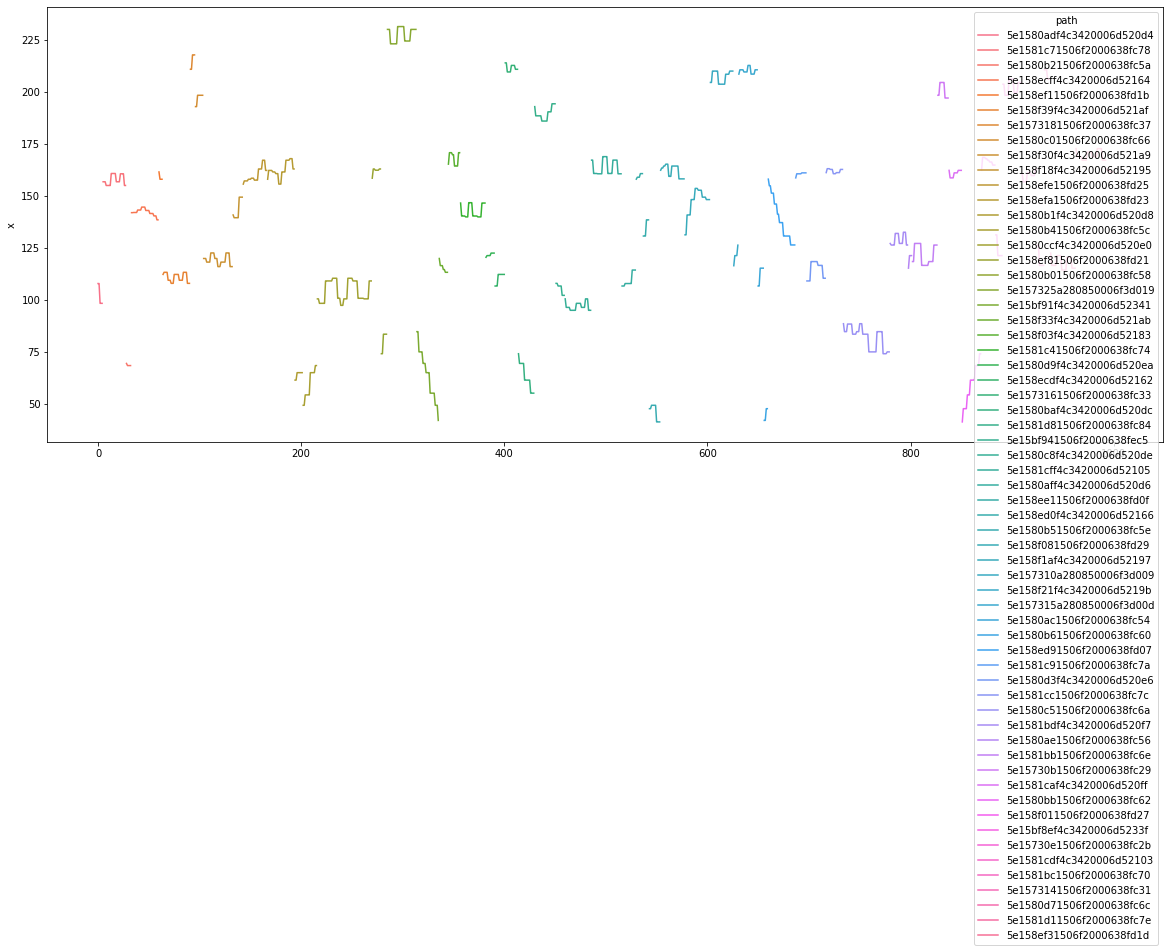

In [18]:
plt.figure(figsize=(20,8))
sns.lineplot(data=tmp, x=tmp.index, y='x', hue='path')

## Modeling

In [27]:
class IndoorDataset(Dataset):
    def __init__(self, data, flag='TRAIN', seq_len=5):
        self.data = data
        self.flag = flag
        self.seq_len = seq_len
    def __len__(self):
        #return self.data.shape[0] - self.seq_len - 1
        #return self.data.shape[0]
        return math.ceil(self.data.shape[0] / self.seq_len)
    def __getitem__(self, index):
        tmp_data = self.data.iloc[index * self.seq_len:(index + 1) * self.seq_len]
        #tmp_data = self.data.iloc[index:index + self.seq_len]
        if tmp_data.shape[0] != self.seq_len:
            temp_len = tmp_data.shape[0]
            diff = self.seq_len - temp_len
            #print("temp_len: ",temp_len)
            #print("diff: ",diff)
            #print("tmp_data shape", tmp_data.shape)
            for i in range(diff):
                _temp = tmp_data.iloc[-1,:]
                tmp_data = tmp_data.append(_temp)
                #print("tmp_data shape", tmp_data.shape)
            
        if self.flag == 'TRAIN':
            return {
                'BSSID_FEATS':tmp_data[BSSID_FEATS].values.astype(float),
                'RSSI_FEATS':tmp_data[RSSI_FEATS].values.astype(float),
                'site_id':tmp_data['site_id'].values.astype(int),
                'x':tmp_data['x'].values,
                'y':tmp_data['y'].values,
                'floor':tmp_data['floor'].values,
            }
        else:
            return {
                'BSSID_FEATS':tmp_data[BSSID_FEATS].values.astype(float),
                'RSSI_FEATS':tmp_data[RSSI_FEATS].values.astype(float),
                'site_id':tmp_data['site_id'].values.astype(int)
            }

In [26]:
math.ceil(1002 / 5)

201

In [28]:
train_dataset = IndoorDataset(data.iloc[:1000,:])
data.shape, len(train_dataset)
device = 'cuda'
pbar = tqdm(DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=1, pin_memory=True), position=0)
for temp in pbar:
    pass
    #print(temp['BSSID_FEATS'].to(device).long())
    #break
#temp['BSSID_FEATS'].to(device).long().size()
#_temp = data.copy()
#temp = data.iloc[-1,:]
#temp = pd.concat([_temp,temp])
#temp.shape

100%|██████████| 20/20 [00:07<00:00,  2.65it/s]


In [29]:
class SimpleLSTM(nn.Module):
    def __init__(self, embedding_dim = 64, seq_len=20, site_dim=2):
        super(SimpleLSTM, self).__init__()
        self.embedding_dim = embedding_dim
        self.seq_len = seq_len
        self.site_dim = site_dim
        self.emb_BSSID_FEATS = nn.Embedding(wifi_bssids_size, embedding_dim)
        self.emb_site_id = nn.Embedding(site_count, site_dim)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=128, dropout=0.3, bidirectional=False, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128,hidden_size=16, dropout=0.1, bidirectional=False, batch_first=True)
        self.lr = nn.Linear(NUM_FEATS, NUM_FEATS * embedding_dim)
        self.lr1 = nn.Linear(NUM_FEATS * embedding_dim + NUM_FEATS * embedding_dim + site_dim, 256)
        self.lr_xy = nn.Linear(16, 2)
        self.lr_floor = nn.Linear(16, 1)
        #self.batch_norm1 = nn.BatchNorm1d(NUM_FEATS)
        #self.batch_norm1 = nn.LayerNorm(NUM_FEATS)
        self.batch_norm1 = nn.LayerNorm(NUM_FEATS * embedding_dim)
        #self.batch_norm2 = nn.BatchNorm1d(NUM_FEATS * embedding_dim + NUM_FEATS * embedding_dim + site_dim)
        #self.batch_norm2 = nn.LayerNorm(NUM_FEATS * embedding_dim + NUM_FEATS * embedding_dim + site_dim)
        self.batch_norm2 = nn.LayerNorm(256)
        #self.batch_norm3 = nn.BatchNorm1d(1)
        #self.batch_norm3 = nn.LayerNorm(256)
        self.batch_norm3 = nn.LayerNorm(2)
        self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        
        x_bssid = self.emb_BSSID_FEATS(x['BSSID_FEATS'])
        x_bssid = torch.flatten(x_bssid, start_dim=-2)
        
        x_site_id = self.emb_site_id(x['site_id'])
        x_site_id = torch.flatten(x_site_id, start_dim=-1)

        #x_rssi = self.batch_norm1(x['RSSI_FEATS'])
        x_rssi = self.lr(x['RSSI_FEATS'])
        x_rssi = self.batch_norm1(x_rssi)
        x_rssi = torch.relu(x_rssi)
        #x_rssi = self.dropout(x_rssi)
        
        x = torch.cat([x_bssid, x_site_id, x_rssi], dim=-1)
        x = self.lr1(x)
        x = self.batch_norm2(x)
        x = torch.relu(x)
        x = self.dropout(x)

        #x = x.unsqueeze(-2)
        #x = self.batch_norm3(x)
        
        #x = x.reshape(self.seq_len, -1, 256) # (all_seq, 1, feat) -> (seq_len, batch, feat)
        #x = x.transpose(0, 1)
        x, _ = self.lstm1(x)
        #x = x.transpose(0, 1)
        x = torch.relu(x)
        #x = x.transpose(0, 1)
        x, _ = self.lstm2(x)
        #x = x.transpose(0, 1)
        x = torch.relu(x)
        #x = x.reshape(-1, 16)
        xy = self.lr_xy(x)
        #xy = self.batch_norm3(xy)
        floor = self.lr_floor(x)
        floor = torch.relu(floor)
        return xy.squeeze(-2), floor.squeeze(-2)

In [36]:
def evaluate(net, data_loader,  device='cuda'):
    net.to(device)
    net.eval()
    x_list = []
    y_list = []
    floor_list = []
    prexs_list = []
    preys_list = []
    prefloors_list = []
    for d in tqdm(data_loader, position=0):
        data_dict = {}
        data_dict['BSSID_FEATS'] = d['BSSID_FEATS'].to(device).long()
        data_dict['RSSI_FEATS'] = d['RSSI_FEATS'].to(device).float()
        data_dict['site_id'] = d['site_id'].to(device).long()
        x = d['x'].to(device).float()
        y = d['y'].to(device).float()
        floor = d['floor'].to(device).long()
        x_list.append(x.cpu().detach().numpy())
        y_list.append(y.cpu().detach().numpy())
        floor_list.append(floor.cpu().detach().numpy())
        xy, floor = net(data_dict)
        prexs_list.append(xy[:, :, 0].cpu().detach().numpy())
        preys_list.append(xy[:, :, 1].cpu().detach().numpy())
        prefloors_list.append(floor.squeeze().cpu().detach().numpy())
    x = np.concatenate(x_list)
    y = np.concatenate(y_list)
    floor = np.concatenate(floor_list)
    prexs = np.concatenate(prexs_list)
    preys =np.concatenate(preys_list)
    prefloors = np.concatenate(prefloors_list)
    eval_score = comp_metric(x, y, floor, prexs, preys, prefloors)
    xy_score = comp_xy(x, y, prexs, preys)
    return eval_score, xy_score
def get_result(net, data_loader, device='cuda'):
    net.eval()
    net.to(device)
    prexs_list = []
    preys_list = []
    prefloors_list = []
    data_dict = {}
    for d in tqdm(data_loader, position=0):
        data_dict['BSSID_FEATS'] = d['BSSID_FEATS'].to(device).long()
        data_dict['RSSI_FEATS'] = d['RSSI_FEATS'].to(device).float()
        data_dict['site_id'] = d['site_id'].to(device).long()
        xy, floor = net(data_dict)
        prexs_list.append(xy[:, :, 0].cpu().detach().numpy().reshape(-1,1).squeeze())
        preys_list.append(xy[:, :, 1].cpu().detach().numpy().reshape(-1,1).squeeze())
        prefloors_list.append(floor[:,:].squeeze(-1).cpu().detach().numpy().reshape(-1,1).squeeze())
    prexs = np.concatenate(prexs_list)
    preys =np.concatenate(preys_list)
    prefloors = np.concatenate(prefloors_list)
    #prefloors = np.argmax(prefloors,axis=1)
    return prexs, preys, prefloors

In [37]:
#score = evaluate(net, valid_dataloader, device)
#test_x, test_y, test_floor = get_result(best_model, test_dataloader, device)

100%|██████████| 16/16 [00:01<00:00,  9.35it/s]


## Training

In [43]:
SEQ_LEN = 5
BATCH_SIZE = 128
EMB_DIM = 64
SITE_DIM = 2
NUM_EPOCHS = 100
DEBUG = False
if DEBUG:
    inputs_data = data.iloc[:1000]
    NUM_EPOCHS = 5
else:
    inputs_data = data

score_df = pd.DataFrame()
oof = list()
predictions = list()

oof_x, oof_y, oof_f = np.zeros(inputs_data.shape[0]), np.zeros(inputs_data.shape[0]), np.zeros(inputs_data.shape[0])
preds_x, preds_y = 0, 0
preds_f_arr = np.zeros((test_data.shape[0], N_SPLITS))


for fold, (trn_idx, val_idx) in enumerate(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED).split(inputs_data.loc[:, 'path'], inputs_data.loc[:, 'path'])):

    train_data = inputs_data.loc[trn_idx]
    valid_data = inputs_data.loc[val_idx]
    train_dataset = IndoorDataset(train_data, seq_len=SEQ_LEN)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    valid_dataset = IndoorDataset(valid_data, seq_len=SEQ_LEN)
    valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    test_dataset = IndoorDataset(test_data, 'TEST', seq_len=SEQ_LEN)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    net = SimpleLSTM(embedding_dim=EMB_DIM, site_dim=SITE_DIM)
    net = net.to(device)

    mse = nn.MSELoss()
    mse = mse.to(device)
    optim = torch.optim.Adam(net.parameters(), lr=5e-3)

    best_loss = 10000000000
    best_epoch = 0
    for epoch in range(NUM_EPOCHS):
        net.train()
        losses = []
        pbar = tqdm(train_dataloader, position=0)
        for d in pbar:
            data_dict = {}
            data_dict['BSSID_FEATS'] = d['BSSID_FEATS'].to(device).long()
            data_dict['RSSI_FEATS'] = d['RSSI_FEATS'].to(device).float()
            data_dict['site_id'] = d['site_id'].to(device).long()
            x = d['x'].to(device).float().unsqueeze(-1)
            y = d['y'].to(device).float().unsqueeze(-1)
            floor = d['floor'].to(device).long()
            xy, floor = net(data_dict)
            label = torch.cat([x, y], dim=-1)
            loss = mse(xy, label)
            loss.backward()
            optim.step()
            optim.zero_grad()
            losses.append(loss.cpu().detach().numpy())
            pbar.set_description(f'loss:{np.mean(losses)}')
            data_dict['BSSID_FEATS'] = data_dict['BSSID_FEATS'].detach()
            data_dict['RSSI_FEATS'] = data_dict['RSSI_FEATS'].detach()
            data_dict['site_id'] = data_dict['site_id'].detach()
            #del x, y, xy, floor, label, data_dict, loss, d
            gc.collect()
            torch.cuda.empty_cache()
        score, xy_score = evaluate(net, valid_dataloader, device)
        if xy_score < best_loss:
            best_loss = xy_score
            best_epoch = epoch
            best_model = copy.deepcopy(net)
        if best_epoch + 25 < epoch:
            break
        print("*="*50)
        print(f"fold {fold} EPOCH {epoch}: mean position error with floor {score}")
        print(f"fold {fold} EPOCH {epoch}: mean position error without floor {xy_score}")
        print("*="*50)
    test_x, test_y, test_floor = get_result(best_model, test_dataloader, device)
    test_size = test_data.shape[0]
    preds_f_arr[:,fold] = test_floor[:test_size]
    preds_x += test_x[:test_size]
    preds_y += test_y[:test_size]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 0: mean position error with floor 867.0697729078606
fold 0 EPOCH 0: mean position error without floor 741.5448426150122
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 1: mean position error with floor 787.5526233168722
fold 0 EPOCH 1: mean position error without floor 662.0276997578693
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 2: mean position error with floor 719.5637663405051
fold 0 EPOCH 2: mean position error without floor 594.038789346247
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 3: mean position error with floor 663.7875370027049
fold 0 EPOCH 3: mean position error without floor 538.2626150121065
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 4: mean position error with floor 619.9983264134554
fold 0 EPOCH 4: mean position error without floor 494.4733656174334
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 5: mean position error with floor 587.3853012836933
fold 0 EPOCH 5: mean position error without floor 461.860387409201
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 6: mean position error with floor 564.3935823651059
fold 0 EPOCH 6: mean position error without floor 438.86861985472154
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 7: mean position error with floor 549.4451739107841
fold 0 EPOCH 7: mean position error without floor 423.9202421307506
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 8: mean position error with floor 540.5645078270054
fold 0 EPOCH 8: mean position error without floor 415.03956416464894
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 9: mean position error with floor 535.9844467722041
fold 0 EPOCH 9: mean position error without floor 410.4595157384988
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 10: mean position error with floor 534.154829232827
fold 0 EPOCH 10: mean position error without floor 408.62992736077484
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 11: mean position error with floor 533.863124327368
fold 0 EPOCH 11: mean position error without floor 408.33820823244554
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 12: mean position error with floor 534.2717609275477
fold 0 EPOCH 12: mean position error without floor 408.74682808716705
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 13: mean position error with floor 534.8276474225262
fold 0 EPOCH 13: mean position error without floor 409.3027118644068
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 14: mean position error with floor 535.2998460509147
fold 0 EPOCH 14: mean position error without floor 409.77491525423727
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 15: mean position error with floor 535.6177024218692
fold 0 EPOCH 15: mean position error without floor 410.09278450363195
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 16: mean position error with floor 535.7925448030247
fold 0 EPOCH 16: mean position error without floor 410.267602905569
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 17: mean position error with floor 535.8300024591895
fold 0 EPOCH 17: mean position error without floor 410.3050363196126
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 18: mean position error with floor 535.853972465432
fold 0 EPOCH 18: mean position error without floor 410.3290072639225
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 19: mean position error with floor 535.8693679478729
fold 0 EPOCH 19: mean position error without floor 410.344406779661
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 20: mean position error with floor 535.8624543044181
fold 0 EPOCH 20: mean position error without floor 410.33753026634383
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 21: mean position error with floor 535.8211967425658
fold 0 EPOCH 21: mean position error without floor 410.29622276029056
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 22: mean position error with floor 535.875143022999
fold 0 EPOCH 22: mean position error without floor 410.35021791767554
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 23: mean position error with floor 535.7916310100867
fold 0 EPOCH 23: mean position error without floor 410.2666828087167
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 24: mean position error with floor 535.7892127263401
fold 0 EPOCH 24: mean position error without floor 410.2642615012106
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 25: mean position error with floor 437.94846761950566
fold 0 EPOCH 25: mean position error without floor 312.4737288135593
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 26: mean position error with floor 397.9939690523943
fold 0 EPOCH 26: mean position error without floor 272.4828813559322
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 27: mean position error with floor 336.1713555945727
fold 0 EPOCH 27: mean position error without floor 210.74443099273608
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 28: mean position error with floor 306.4280436288986
fold 0 EPOCH 28: mean position error without floor 181.0101573849879
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 29: mean position error with floor 279.50251663585544
fold 0 EPOCH 29: mean position error without floor 153.9820460048426
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 30: mean position error with floor 260.68462252838054
fold 0 EPOCH 30: mean position error without floor 135.40462469733657
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 31: mean position error with floor 245.50600556349954
fold 0 EPOCH 31: mean position error without floor 120.44559322033898
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 32: mean position error with floor 233.17854268199306
fold 0 EPOCH 32: mean position error without floor 108.33210653753027
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 33: mean position error with floor 223.55406429058414
fold 0 EPOCH 33: mean position error without floor 98.56313559322034
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 34: mean position error with floor 214.5187829731257
fold 0 EPOCH 34: mean position error without floor 89.45306295399516
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 35: mean position error with floor 207.29335132434423
fold 0 EPOCH 35: mean position error without floor 82.17651937046004
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 36: mean position error with floor 201.36721170262874
fold 0 EPOCH 36: mean position error without floor 76.21922518159806
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 37: mean position error with floor 195.92927462400846
fold 0 EPOCH 37: mean position error without floor 70.76345036319613
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 38: mean position error with floor 192.16915183313174
fold 0 EPOCH 38: mean position error without floor 66.95164648910412
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 39: mean position error with floor 187.56264762112957
fold 0 EPOCH 39: mean position error without floor 62.33518159806295
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 40: mean position error with floor 184.76599311147112
fold 0 EPOCH 40: mean position error without floor 59.52532082324455
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 41: mean position error with floor 182.11963617226294
fold 0 EPOCH 41: mean position error without floor 56.88526634382566
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 42: mean position error with floor 180.3649767393711
fold 0 EPOCH 42: mean position error without floor 55.06302663438257
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 43: mean position error with floor 177.757550044343
fold 0 EPOCH 43: mean position error without floor 52.46932203389831
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 44: mean position error with floor 177.23699616110932
fold 0 EPOCH 44: mean position error without floor 51.92835956416465
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 45: mean position error with floor 176.33453149060279
fold 0 EPOCH 45: mean position error without floor 51.00210653753027
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 46: mean position error with floor 173.4961053317787
fold 0 EPOCH 46: mean position error without floor 48.13014225181598
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 47: mean position error with floor 172.9591746172796
fold 0 EPOCH 47: mean position error without floor 47.58851392251816
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 48: mean position error with floor 171.86239961877646
fold 0 EPOCH 48: mean position error without floor 46.452696731234866
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 49: mean position error with floor 171.10587869587843
fold 0 EPOCH 49: mean position error without floor 45.67764225181598
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 50: mean position error with floor 170.25667327243536
fold 0 EPOCH 50: mean position error without floor 44.82248789346247
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 51: mean position error with floor 169.9844560089267
fold 0 EPOCH 51: mean position error without floor 44.54710956416465
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 52: mean position error with floor 169.26104326954695
fold 0 EPOCH 52: mean position error without floor 43.808607748184016
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 53: mean position error with floor 169.1206962505613
fold 0 EPOCH 53: mean position error without floor 43.66040556900727
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 54: mean position error with floor 168.06855498317745
fold 0 EPOCH 54: mean position error without floor 42.60398305084746
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 55: mean position error with floor 167.91392097936162
fold 0 EPOCH 55: mean position error without floor 42.44804479418886
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 56: mean position error with floor 167.46843123881493
fold 0 EPOCH 56: mean position error without floor 42.00006053268765
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 57: mean position error with floor 167.0646594751509
fold 0 EPOCH 57: mean position error without floor 41.592720944309924
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 58: mean position error with floor 167.2130830995219
fold 0 EPOCH 58: mean position error without floor 41.73449152542373
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 59: mean position error with floor 166.37658556943043
fold 0 EPOCH 59: mean position error without floor 40.89845641646489
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 60: mean position error with floor 166.4560803681495
fold 0 EPOCH 60: mean position error without floor 40.97568704600484
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 61: mean position error with floor 166.23410875097892
fold 0 EPOCH 61: mean position error without floor 40.74502421307506
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 62: mean position error with floor 165.71254819030082
fold 0 EPOCH 62: mean position error without floor 40.22222154963681
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 63: mean position error with floor 165.65968349151458
fold 0 EPOCH 63: mean position error without floor 40.176216707021794
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 64: mean position error with floor 165.32852702845707
fold 0 EPOCH 64: mean position error without floor 39.8376392251816
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 65: mean position error with floor 165.0226339068345
fold 0 EPOCH 65: mean position error without floor 39.52913438256659
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 66: mean position error with floor 164.9731186248178
fold 0 EPOCH 66: mean position error without floor 39.47736380145278
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 67: mean position error with floor 165.0275969912339
fold 0 EPOCH 67: mean position error without floor 39.52744552058111
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 68: mean position error with floor 164.83637119298228
fold 0 EPOCH 68: mean position error without floor 39.33266949152542
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 69: mean position error with floor 164.78849921548303
fold 0 EPOCH 69: mean position error without floor 39.28328692493947
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 70: mean position error with floor 164.44651838164336
fold 0 EPOCH 70: mean position error without floor 38.942109564164646
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 71: mean position error with floor 164.60548174265583
fold 0 EPOCH 71: mean position error without floor 39.10264830508475
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 72: mean position error with floor 164.96865938870096
fold 0 EPOCH 72: mean position error without floor 39.465039346246975
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 73: mean position error with floor 164.15978390879405
fold 0 EPOCH 73: mean position error without floor 38.65377421307506
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 74: mean position error with floor 164.42909644332676
fold 0 EPOCH 74: mean position error without floor 38.92265738498789
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 75: mean position error with floor 163.95515510720145
fold 0 EPOCH 75: mean position error without floor 38.448535108958836
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 76: mean position error with floor 163.9969602204044
fold 0 EPOCH 76: mean position error without floor 38.48599878934625
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 77: mean position error with floor 164.11397012851518
fold 0 EPOCH 77: mean position error without floor 38.608193099273606
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 78: mean position error with floor 164.3082839885823
fold 0 EPOCH 78: mean position error without floor 38.797421307506056
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 79: mean position error with floor 163.92292199017407
fold 0 EPOCH 79: mean position error without floor 38.41332929782082
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 80: mean position error with floor 163.837300866011
fold 0 EPOCH 80: mean position error without floor 38.32730629539952
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 81: mean position error with floor 163.799756703831
fold 0 EPOCH 81: mean position error without floor 38.29248486682809
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 82: mean position error with floor 163.50163637113738
fold 0 EPOCH 82: mean position error without floor 37.99195823244552
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 83: mean position error with floor 163.73507028084222
fold 0 EPOCH 83: mean position error without floor 38.223756053268765
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 84: mean position error with floor 163.5721710815914
fold 0 EPOCH 84: mean position error without floor 38.05805387409201
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 85: mean position error with floor 163.8815719748202
fold 0 EPOCH 85: mean position error without floor 38.36470338983051
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 86: mean position error with floor 163.85065765326848
fold 0 EPOCH 86: mean position error without floor 38.33250907990315
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 87: mean position error with floor 163.16300259105464
fold 0 EPOCH 87: mean position error without floor 37.64613196125908
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 88: mean position error with floor 163.37221467582316
fold 0 EPOCH 88: mean position error without floor 37.85418886198547
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 89: mean position error with floor 163.77442712774882
fold 0 EPOCH 89: mean position error without floor 38.25700060532688
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 90: mean position error with floor 163.62872875436383
fold 0 EPOCH 90: mean position error without floor 38.11032687651332
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 91: mean position error with floor 163.43867051183545
fold 0 EPOCH 91: mean position error without floor 37.919791162227604
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 92: mean position error with floor 163.5190525266014
fold 0 EPOCH 92: mean position error without floor 38.00135290556901
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 93: mean position error with floor 162.94869227954717
fold 0 EPOCH 93: mean position error without floor 37.427611985472154
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 94: mean position error with floor 163.27946366019032
fold 0 EPOCH 94: mean position error without floor 37.75876210653753
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 95: mean position error with floor 163.12909962020365
fold 0 EPOCH 95: mean position error without floor 37.60819612590799
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 96: mean position error with floor 162.8078030062455
fold 0 EPOCH 96: mean position error without floor 37.286549636803876
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 97: mean position error with floor 163.12326736336146
fold 0 EPOCH 97: mean position error without floor 37.601549636803874
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 98: mean position error with floor 163.14986247398735
fold 0 EPOCH 98: mean position error without floor 37.629791162227605
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/16 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 0 EPOCH 99: mean position error with floor 163.01796996408626
fold 0 EPOCH 99: mean position error without floor 37.496858353510895
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 0: mean position error with floor 846.6071224815751
fold 1 EPOCH 0: mean position error without floor 721.6996610169491
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 1: mean position error with floor 753.9335478149271
fold 1 EPOCH 1: mean position error without floor 629.026392251816
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 2: mean position error with floor 679.7122762409322
fold 1 EPOCH 2: mean position error without floor 554.8051331719129
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 3: mean position error with floor 623.9235795038592
fold 1 EPOCH 3: mean position error without floor 499.01646489104115
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 4: mean position error with floor 584.8464839045621
fold 1 EPOCH 4: mean position error without floor 459.93941888619855
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 5: mean position error with floor 559.6014363410296
fold 1 EPOCH 5: mean position error without floor 434.69433414043584
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 6: mean position error with floor 544.93711970681
fold 1 EPOCH 6: mean position error without floor 420.0300242130751
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 7: mean position error with floor 537.547992892069
fold 1 EPOCH 7: mean position error without floor 412.6409200968523
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 8: mean position error with floor 534.6446086485059
fold 1 EPOCH 8: mean position error without floor 409.7374818401937
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 9: mean position error with floor 534.0834689777757
fold 1 EPOCH 9: mean position error without floor 409.1763680387409
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 10: mean position error with floor 534.5090893201722
fold 1 EPOCH 10: mean position error without floor 409.601985472155
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 11: mean position error with floor 535.0975551647626
fold 1 EPOCH 11: mean position error without floor 410.19041162227603
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 12: mean position error with floor 535.5872180749501
fold 1 EPOCH 12: mean position error without floor 410.68009685230027
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 13: mean position error with floor 535.8697388520483
fold 1 EPOCH 13: mean position error without floor 410.96266343825664
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 14: mean position error with floor 535.9967957141613
fold 1 EPOCH 14: mean position error without floor 411.0896852300242
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 15: mean position error with floor 536.0642918659296
fold 1 EPOCH 15: mean position error without floor 411.1572397094431
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 16: mean position error with floor 536.0443244531599
fold 1 EPOCH 16: mean position error without floor 411.1372397094431
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 17: mean position error with floor 536.0509187753495
fold 1 EPOCH 17: mean position error without floor 411.14382566585954
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 18: mean position error with floor 535.9945963118656
fold 1 EPOCH 18: mean position error without floor 411.0875060532688
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 19: mean position error with floor 535.9083329500269
fold 1 EPOCH 19: mean position error without floor 411.00125907990315
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 20: mean position error with floor 536.0413309920801
fold 1 EPOCH 20: mean position error without floor 411.1342372881356
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 21: mean position error with floor 536.0085546226998
fold 1 EPOCH 21: mean position error without floor 411.10145278450364
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 22: mean position error with floor 418.78357946628086
fold 1 EPOCH 22: mean position error without floor 293.444794188862
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 23: mean position error with floor 379.8448275832049
fold 1 EPOCH 23: mean position error without floor 254.34941888619855
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 24: mean position error with floor 332.40927132897457
fold 1 EPOCH 24: mean position error without floor 206.98365617433413
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 25: mean position error with floor 298.7911603471835
fold 1 EPOCH 25: mean position error without floor 174.33433414043583
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 26: mean position error with floor 271.3843793496969
fold 1 EPOCH 26: mean position error without floor 146.76733656174335
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 27: mean position error with floor 250.8930179432565
fold 1 EPOCH 27: mean position error without floor 125.93674334140435
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 28: mean position error with floor 235.36608232478522
fold 1 EPOCH 28: mean position error without floor 110.39830508474576
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 29: mean position error with floor 222.86553474751264
fold 1 EPOCH 29: mean position error without floor 97.75986682808717
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 30: mean position error with floor 213.06238870205226
fold 1 EPOCH 30: mean position error without floor 87.88451573849879
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 31: mean position error with floor 204.85387003592083
fold 1 EPOCH 31: mean position error without floor 79.66536319612591
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 32: mean position error with floor 198.53101611780647
fold 1 EPOCH 32: mean position error without floor 73.31243341404358
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 33: mean position error with floor 193.20213213005778
fold 1 EPOCH 33: mean position error without floor 67.93513317191284
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 34: mean position error with floor 189.29973187110795
fold 1 EPOCH 34: mean position error without floor 64.01252421307505
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 35: mean position error with floor 185.611202660722
fold 1 EPOCH 35: mean position error without floor 60.25567191283293
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 36: mean position error with floor 182.7753010018877
fold 1 EPOCH 36: mean position error without floor 57.42684624697337
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 37: mean position error with floor 180.36394746850084
fold 1 EPOCH 37: mean position error without floor 55.00021186440678
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 38: mean position error with floor 178.76475826012435
fold 1 EPOCH 38: mean position error without floor 53.36711259079903
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 39: mean position error with floor 176.82713162023907
fold 1 EPOCH 39: mean position error without floor 51.44574455205811
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 40: mean position error with floor 175.5940095078754
fold 1 EPOCH 40: mean position error without floor 50.22300847457627
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 41: mean position error with floor 174.34743584012094
fold 1 EPOCH 41: mean position error without floor 48.92712469733656
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 42: mean position error with floor 172.936938610862
fold 1 EPOCH 42: mean position error without floor 47.51001210653753
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 43: mean position error with floor 172.683393588634
fold 1 EPOCH 43: mean position error without floor 47.22937348668281
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 44: mean position error with floor 172.08378286683757
fold 1 EPOCH 44: mean position error without floor 46.62065375302664
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 45: mean position error with floor 170.7496604821813
fold 1 EPOCH 45: mean position error without floor 45.257730024213075
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 46: mean position error with floor 170.3231881125907
fold 1 EPOCH 46: mean position error without floor 44.846601089588376
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 47: mean position error with floor 169.57047325868476
fold 1 EPOCH 47: mean position error without floor 44.09705811138014
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 48: mean position error with floor 168.9794655713872
fold 1 EPOCH 48: mean position error without floor 43.48894673123487
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 49: mean position error with floor 169.11591431864633
fold 1 EPOCH 49: mean position error without floor 43.624098062954
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 50: mean position error with floor 168.47316721043236
fold 1 EPOCH 50: mean position error without floor 42.969203995157386
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 51: mean position error with floor 168.03444241500435
fold 1 EPOCH 51: mean position error without floor 42.53100181598063
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 52: mean position error with floor 167.57326518086938
fold 1 EPOCH 52: mean position error without floor 42.064058716707024
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 53: mean position error with floor 167.2783923554471
fold 1 EPOCH 53: mean position error without floor 41.771728208232446
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 54: mean position error with floor 167.30608861689345
fold 1 EPOCH 54: mean position error without floor 41.80205205811138
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 55: mean position error with floor 167.0481855752801
fold 1 EPOCH 55: mean position error without floor 41.538874092009685
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 56: mean position error with floor 166.5815839251369
fold 1 EPOCH 56: mean position error without floor 41.06946428571428
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 57: mean position error with floor 166.74951369486217
fold 1 EPOCH 57: mean position error without floor 41.238858958837774
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 58: mean position error with floor 166.36192685164005
fold 1 EPOCH 58: mean position error without floor 40.85046307506053
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 59: mean position error with floor 166.17244055227383
fold 1 EPOCH 59: mean position error without floor 40.65241828087167
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 60: mean position error with floor 166.41821288003524
fold 1 EPOCH 60: mean position error without floor 40.89573244552058
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 61: mean position error with floor 165.71263723334474
fold 1 EPOCH 61: mean position error without floor 40.20028450363196
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 62: mean position error with floor 165.85396650839064
fold 1 EPOCH 62: mean position error without floor 40.344651937046
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 63: mean position error with floor 165.22908718008594
fold 1 EPOCH 63: mean position error without floor 39.72523607748184
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 64: mean position error with floor 165.67555418317457
fold 1 EPOCH 64: mean position error without floor 40.16902239709443
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 65: mean position error with floor 165.3559244174144
fold 1 EPOCH 65: mean position error without floor 39.84916464891041
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 66: mean position error with floor 165.18308174860138
fold 1 EPOCH 66: mean position error without floor 39.68464588377724
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 67: mean position error with floor 165.3633883378431
fold 1 EPOCH 67: mean position error without floor 39.859479418886195
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 68: mean position error with floor 165.12739535030022
fold 1 EPOCH 68: mean position error without floor 39.625841404358354
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 69: mean position error with floor 164.97771766155472
fold 1 EPOCH 69: mean position error without floor 39.471495157384986
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 70: mean position error with floor 164.8388309345181
fold 1 EPOCH 70: mean position error without floor 39.33091101694915
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 71: mean position error with floor 164.87859870849192
fold 1 EPOCH 71: mean position error without floor 39.38526634382566
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 72: mean position error with floor 164.62894707181894
fold 1 EPOCH 72: mean position error without floor 39.127033898305086
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 73: mean position error with floor 164.76803238160747
fold 1 EPOCH 73: mean position error without floor 39.272624092009686
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 74: mean position error with floor 164.39569238616266
fold 1 EPOCH 74: mean position error without floor 38.89541162227603
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 75: mean position error with floor 164.6571984983959
fold 1 EPOCH 75: mean position error without floor 39.15977300242131
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 76: mean position error with floor 164.4751075877904
fold 1 EPOCH 76: mean position error without floor 38.98114406779661
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 77: mean position error with floor 164.42950406304897
fold 1 EPOCH 77: mean position error without floor 38.92744552058112
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 78: mean position error with floor 164.00632877175082
fold 1 EPOCH 78: mean position error without floor 38.50436440677966
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 79: mean position error with floor 164.15292664260735
fold 1 EPOCH 79: mean position error without floor 38.65192191283293
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 80: mean position error with floor 163.9580688049563
fold 1 EPOCH 80: mean position error without floor 38.456458837772395
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 81: mean position error with floor 164.14765650891292
fold 1 EPOCH 81: mean position error without floor 38.647763317191284
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 82: mean position error with floor 163.9852500566521
fold 1 EPOCH 82: mean position error without floor 38.489182808716706
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 83: mean position error with floor 163.79831629367413
fold 1 EPOCH 83: mean position error without floor 38.29743644067796
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 84: mean position error with floor 163.7838672293543
fold 1 EPOCH 84: mean position error without floor 38.280266343825666
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 85: mean position error with floor 164.01429583365797
fold 1 EPOCH 85: mean position error without floor 38.51572033898305
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 86: mean position error with floor 164.03374779872172
fold 1 EPOCH 86: mean position error without floor 38.52961259079903
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 87: mean position error with floor 163.72037813415648
fold 1 EPOCH 87: mean position error without floor 38.216361985472155
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 88: mean position error with floor 163.83100996680378
fold 1 EPOCH 88: mean position error without floor 38.33129539951574
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 89: mean position error with floor 163.8216202573029
fold 1 EPOCH 89: mean position error without floor 38.32057506053269
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 90: mean position error with floor 163.722487773163
fold 1 EPOCH 90: mean position error without floor 38.2222397094431
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 91: mean position error with floor 163.73568131581635
fold 1 EPOCH 91: mean position error without floor 38.23644370460048
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 92: mean position error with floor 163.73920117695255
fold 1 EPOCH 92: mean position error without floor 38.239219128329296
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 93: mean position error with floor 163.6270503111244
fold 1 EPOCH 93: mean position error without floor 38.12812348668281
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 94: mean position error with floor 163.5934222694978
fold 1 EPOCH 94: mean position error without floor 38.09438861985472
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 95: mean position error with floor 163.58581823549858
fold 1 EPOCH 95: mean position error without floor 38.089140435835354
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 96: mean position error with floor 163.40186001884302
fold 1 EPOCH 96: mean position error without floor 37.906374092009685
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 97: mean position error with floor 163.22631147352172
fold 1 EPOCH 97: mean position error without floor 37.728492736077484
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 98: mean position error with floor 163.7410276884847
fold 1 EPOCH 98: mean position error without floor 38.2405901937046
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/16 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 1 EPOCH 99: mean position error with floor 163.75186712283343
fold 1 EPOCH 99: mean position error without floor 38.25069007263922
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 0: mean position error with floor 908.3923698708394
fold 2 EPOCH 0: mean position error without floor 782.8616464891041
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 1: mean position error with floor 860.3210541931394
fold 2 EPOCH 1: mean position error without floor 734.7902663438257
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 2: mean position error with floor 815.2164286268941
fold 2 EPOCH 2: mean position error without floor 689.6856658595642
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 3: mean position error with floor 773.224803190774
fold 2 EPOCH 3: mean position error without floor 647.6940920096853
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 4: mean position error with floor 734.5573307055827
fold 2 EPOCH 4: mean position error without floor 609.0265375302663
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 5: mean position error with floor 699.5379388302492
fold 2 EPOCH 5: mean position error without floor 574.0072154963681
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 6: mean position error with floor 668.1357723786294
fold 2 EPOCH 6: mean position error without floor 542.6049878934625
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 7: mean position error with floor 640.415561954519
fold 2 EPOCH 7: mean position error without floor 514.884794188862
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 8: mean position error with floor 616.4530387350527
fold 2 EPOCH 8: mean position error without floor 490.9223244552058
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 9: mean position error with floor 596.0562285424173
fold 2 EPOCH 9: mean position error without floor 470.5255205811138
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 10: mean position error with floor 579.0539263088103
fold 2 EPOCH 10: mean position error without floor 453.523196125908
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 11: mean position error with floor 565.2695801121617
fold 2 EPOCH 11: mean position error without floor 439.7388377723971
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 12: mean position error with floor 554.4778877363915
fold 2 EPOCH 12: mean position error without floor 428.9471670702179
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 13: mean position error with floor 546.3396769427878
fold 2 EPOCH 13: mean position error without floor 420.8089588377724
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 14: mean position error with floor 540.4674439588124
fold 2 EPOCH 14: mean position error without floor 414.9367070217918
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 15: mean position error with floor 536.4997371659065
fold 2 EPOCH 15: mean position error without floor 410.9689588377724
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 16: mean position error with floor 534.1071064897311
fold 2 EPOCH 16: mean position error without floor 408.5763680387409
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 17: mean position error with floor 532.881968283636
fold 2 EPOCH 17: mean position error without floor 407.35123486682807
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 18: mean position error with floor 532.476890680686
fold 2 EPOCH 18: mean position error without floor 406.9461501210654
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 19: mean position error with floor 532.5807887115433
fold 2 EPOCH 19: mean position error without floor 407.05002421307506
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 20: mean position error with floor 532.927570488144
fold 2 EPOCH 20: mean position error without floor 407.39685230024213
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 21: mean position error with floor 533.3475501263315
fold 2 EPOCH 21: mean position error without floor 407.816803874092
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 22: mean position error with floor 533.7297262940338
fold 2 EPOCH 22: mean position error without floor 408.19898305084746
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 23: mean position error with floor 533.9968960274016
fold 2 EPOCH 23: mean position error without floor 408.46615012106537
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 24: mean position error with floor 534.2140890444335
fold 2 EPOCH 24: mean position error without floor 408.6833414043584
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 25: mean position error with floor 534.3170243531941
fold 2 EPOCH 25: mean position error without floor 408.7862469733656
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 26: mean position error with floor 534.3673164439779
fold 2 EPOCH 26: mean position error without floor 408.8365617433414
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 27: mean position error with floor 534.3644247669862
fold 2 EPOCH 27: mean position error without floor 408.8336561743341
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 28: mean position error with floor 534.4018714869686
fold 2 EPOCH 28: mean position error without floor 408.87108958837774
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 29: mean position error with floor 534.3972093756406
fold 2 EPOCH 29: mean position error without floor 408.8664891041162
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 30: mean position error with floor 534.3613422176625
fold 2 EPOCH 30: mean position error without floor 408.83060532687654
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 31: mean position error with floor 534.3599893852181
fold 2 EPOCH 31: mean position error without floor 408.8292493946731
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 32: mean position error with floor 534.3632283961975
fold 2 EPOCH 32: mean position error without floor 408.83244552058113
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 33: mean position error with floor 531.7373250791351
fold 2 EPOCH 33: mean position error without floor 406.20658595641646
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 34: mean position error with floor 481.5503420261205
fold 2 EPOCH 34: mean position error without floor 356.01961259079906
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 35: mean position error with floor 394.6125468634455
fold 2 EPOCH 35: mean position error without floor 269.08200968523005
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 36: mean position error with floor 380.52830164013346
fold 2 EPOCH 36: mean position error without floor 254.99753026634383
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 37: mean position error with floor 372.4863080794788
fold 2 EPOCH 37: mean position error without floor 246.95554479418885
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 38: mean position error with floor 359.1394544615974
fold 2 EPOCH 38: mean position error without floor 233.60866828087168
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 39: mean position error with floor 328.41749325308615
fold 2 EPOCH 39: mean position error without floor 202.8871549636804
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 40: mean position error with floor 304.2312310180335
fold 2 EPOCH 40: mean position error without floor 178.7011259079903
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 41: mean position error with floor 282.50866639497855
fold 2 EPOCH 41: mean position error without floor 156.9778329297821
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 42: mean position error with floor 262.40353777907734
fold 2 EPOCH 42: mean position error without floor 136.8713680387409
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 43: mean position error with floor 242.5464444923906
fold 2 EPOCH 43: mean position error without floor 117.01567796610169
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 44: mean position error with floor 229.99017731285954
fold 2 EPOCH 44: mean position error without floor 104.45938256658596
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 45: mean position error with floor 219.4943630348532
fold 2 EPOCH 45: mean position error without floor 93.96348668280872
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 46: mean position error with floor 212.3718857912712
fold 2 EPOCH 46: mean position error without floor 86.84113196125908
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 47: mean position error with floor 206.7934006334087
fold 2 EPOCH 47: mean position error without floor 81.26338377723971
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 48: mean position error with floor 200.69429505087706
fold 2 EPOCH 48: mean position error without floor 75.16441888619855
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 49: mean position error with floor 195.94716617292195
fold 2 EPOCH 49: mean position error without floor 70.41685230024213
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 50: mean position error with floor 193.54136430132007
fold 2 EPOCH 50: mean position error without floor 68.01060532687652
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 51: mean position error with floor 189.52616634243878
fold 2 EPOCH 51: mean position error without floor 63.994636803874094
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 52: mean position error with floor 186.40950525487813
fold 2 EPOCH 52: mean position error without floor 60.878389830508475
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 53: mean position error with floor 184.95013954586577
fold 2 EPOCH 53: mean position error without floor 59.418541162227605
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 54: mean position error with floor 182.52301001906793
fold 2 EPOCH 54: mean position error without floor 56.991870460048425
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 55: mean position error with floor 180.481402741781
fold 2 EPOCH 55: mean position error without floor 54.950332929782086
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 56: mean position error with floor 179.36509465119542
fold 2 EPOCH 56: mean position error without floor 53.83412832929782
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 57: mean position error with floor 177.95420708529966
fold 2 EPOCH 57: mean position error without floor 52.423026634382566
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 58: mean position error with floor 177.00817595756408
fold 2 EPOCH 58: mean position error without floor 51.47725181598063
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 59: mean position error with floor 177.0854426446676
fold 2 EPOCH 59: mean position error without floor 51.554449152542375
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 60: mean position error with floor 175.33454116562558
fold 2 EPOCH 60: mean position error without floor 49.80346852300242
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 61: mean position error with floor 174.45611273318167
fold 2 EPOCH 61: mean position error without floor 48.925287530266345
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 62: mean position error with floor 173.9231246215888
fold 2 EPOCH 62: mean position error without floor 48.39200363196126
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 63: mean position error with floor 172.8221229819571
fold 2 EPOCH 63: mean position error without floor 47.291092615012104
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 64: mean position error with floor 172.74128626929863
fold 2 EPOCH 64: mean position error without floor 47.21017857142857
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 65: mean position error with floor 171.8982139533253
fold 2 EPOCH 65: mean position error without floor 46.36732445520581
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 66: mean position error with floor 171.35053312543354
fold 2 EPOCH 66: mean position error without floor 45.819830508474574
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 67: mean position error with floor 171.4129782017362
fold 2 EPOCH 67: mean position error without floor 45.882046004842614
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 68: mean position error with floor 170.80758287296925
fold 2 EPOCH 68: mean position error without floor 45.27686440677966
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 69: mean position error with floor 170.49793734777236
fold 2 EPOCH 69: mean position error without floor 44.96703995157385
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 70: mean position error with floor 170.76363370296056
fold 2 EPOCH 70: mean position error without floor 45.23284200968523
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 71: mean position error with floor 169.89876510396348
fold 2 EPOCH 71: mean position error without floor 44.36800242130751
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 72: mean position error with floor 169.52315601994715
fold 2 EPOCH 72: mean position error without floor 43.99230024213075
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 73: mean position error with floor 169.39264541233695
fold 2 EPOCH 73: mean position error without floor 43.861277239709445
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 74: mean position error with floor 168.51646165721317
fold 2 EPOCH 74: mean position error without floor 42.985027239709446
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 75: mean position error with floor 168.61812784515845
fold 2 EPOCH 75: mean position error without floor 43.086776634382566
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 76: mean position error with floor 168.22619740706162
fold 2 EPOCH 76: mean position error without floor 42.69518765133172
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 77: mean position error with floor 168.1486776860993
fold 2 EPOCH 77: mean position error without floor 42.61751210653753
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 78: mean position error with floor 167.9640980262192
fold 2 EPOCH 78: mean position error without floor 42.43297820823245
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 79: mean position error with floor 168.35676249477842
fold 2 EPOCH 79: mean position error without floor 42.82575363196126
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 80: mean position error with floor 167.77080957419972
fold 2 EPOCH 80: mean position error without floor 42.23984261501211
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 81: mean position error with floor 167.2606793130035
fold 2 EPOCH 81: mean position error without floor 41.729782082324455
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 82: mean position error with floor 167.60732921061762
fold 2 EPOCH 82: mean position error without floor 42.076401331719126
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 83: mean position error with floor 167.17253767576727
fold 2 EPOCH 83: mean position error without floor 41.64173426150121
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 84: mean position error with floor 167.57649950237092
fold 2 EPOCH 84: mean position error without floor 42.0456598062954
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 85: mean position error with floor 166.7112842672569
fold 2 EPOCH 85: mean position error without floor 41.18046307506053
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 86: mean position error with floor 166.80048910130708
fold 2 EPOCH 86: mean position error without floor 41.269748789346245
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 87: mean position error with floor 166.40701133024137
fold 2 EPOCH 87: mean position error without floor 40.87625302663438
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 88: mean position error with floor 166.47842885211273
fold 2 EPOCH 88: mean position error without floor 40.94769975786925
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 89: mean position error with floor 166.09539333189406
fold 2 EPOCH 89: mean position error without floor 40.564630750605325
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 90: mean position error with floor 166.21178601404512
fold 2 EPOCH 90: mean position error without floor 40.681056295399515
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 91: mean position error with floor 166.25705643149612
fold 2 EPOCH 91: mean position error without floor 40.726301452784504
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 92: mean position error with floor 166.1579944674134
fold 2 EPOCH 92: mean position error without floor 40.62721852300242
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 93: mean position error with floor 166.61081484382635
fold 2 EPOCH 93: mean position error without floor 41.08004842615012
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 94: mean position error with floor 166.08643034963356
fold 2 EPOCH 94: mean position error without floor 40.5556598062954
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 95: mean position error with floor 165.64919188332075
fold 2 EPOCH 95: mean position error without floor 40.11832021791768
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 96: mean position error with floor 165.91407004911912
fold 2 EPOCH 96: mean position error without floor 40.38328692493947
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 97: mean position error with floor 165.69254698070014
fold 2 EPOCH 97: mean position error without floor 40.161761501210655
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 98: mean position error with floor 165.86270802754214
fold 2 EPOCH 98: mean position error without floor 40.33190677966102
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/16 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 2 EPOCH 99: mean position error with floor 165.79362719922682
fold 2 EPOCH 99: mean position error without floor 40.262826876513316
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 0: mean position error with floor 876.7235201281208
fold 3 EPOCH 0: mean position error without floor 751.1941888619855
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 1: mean position error with floor 804.4855037165612
fold 3 EPOCH 1: mean position error without floor 678.9562227602905
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 2: mean position error with floor 740.9549793489274
fold 3 EPOCH 2: mean position error without floor 615.4256658595642
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 3: mean position error with floor 686.9608651576522
fold 3 EPOCH 3: mean position error without floor 561.431573849879
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 4: mean position error with floor 642.5592746340017
fold 3 EPOCH 4: mean position error without floor 517.0299273607748
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 5: mean position error with floor 607.4170605016476
fold 3 EPOCH 5: mean position error without floor 481.88774818401936
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 6: mean position error with floor 580.7760119551608
fold 3 EPOCH 6: mean position error without floor 455.24673123486684
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 7: mean position error with floor 561.6172394598483
fold 3 EPOCH 7: mean position error without floor 436.08794188861987
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 8: mean position error with floor 548.7003922223698
fold 3 EPOCH 8: mean position error without floor 423.1710895883777
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 9: mean position error with floor 540.6744070778112
fold 3 EPOCH 9: mean position error without floor 415.14513317191285
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 10: mean position error with floor 536.3100119969025
fold 3 EPOCH 10: mean position error without floor 410.78072639225184
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 11: mean position error with floor 534.3792450904009
fold 3 EPOCH 11: mean position error without floor 408.8499757869249
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 12: mean position error with floor 533.9102523048969
fold 3 EPOCH 12: mean position error without floor 408.3809200968523
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 13: mean position error with floor 534.1951488568535
fold 3 EPOCH 13: mean position error without floor 408.66585956416463
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 14: mean position error with floor 534.7236490645622
fold 3 EPOCH 14: mean position error without floor 409.19433414043584
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 15: mean position error with floor 535.1922898184994
fold 3 EPOCH 15: mean position error without floor 409.6630024213075
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 16: mean position error with floor 535.5458320751894
fold 3 EPOCH 16: mean position error without floor 410.0165133171913
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 17: mean position error with floor 535.758924668095
fold 3 EPOCH 17: mean position error without floor 410.2296368038741
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 18: mean position error with floor 535.8232763015935
fold 3 EPOCH 18: mean position error without floor 410.2939467312349
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 19: mean position error with floor 535.9534585607831
fold 3 EPOCH 19: mean position error without floor 410.4241646489104
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 20: mean position error with floor 535.9036193103334
fold 3 EPOCH 20: mean position error without floor 410.37433414043585
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 21: mean position error with floor 535.9223059446269
fold 3 EPOCH 21: mean position error without floor 410.3930266343826
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 22: mean position error with floor 536.0141554983187
fold 3 EPOCH 22: mean position error without floor 410.4848426150121
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 23: mean position error with floor 535.9496065806419
fold 3 EPOCH 23: mean position error without floor 410.42029055690074
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 24: mean position error with floor 535.9177219676683
fold 3 EPOCH 24: mean position error without floor 410.38842615012106
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 25: mean position error with floor 535.8912547893674
fold 3 EPOCH 25: mean position error without floor 410.36193704600487
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 26: mean position error with floor 534.2550500816612
fold 3 EPOCH 26: mean position error without floor 408.72576271186443
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 27: mean position error with floor 533.3956277607717
fold 3 EPOCH 27: mean position error without floor 407.86634382566587
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 28: mean position error with floor 443.1386405606434
fold 3 EPOCH 28: mean position error without floor 317.6198789346247
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 29: mean position error with floor 391.8457253339843
fold 3 EPOCH 29: mean position error without floor 267.4934382566586
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 30: mean position error with floor 378.9056975161019
fold 3 EPOCH 30: mean position error without floor 256.10861985472155
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 31: mean position error with floor 372.2375029864727
fold 3 EPOCH 31: mean position error without floor 250.4296368038741
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 32: mean position error with floor 366.97912516222164
fold 3 EPOCH 32: mean position error without floor 245.83154963680389
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 33: mean position error with floor 343.3537565227441
fold 3 EPOCH 33: mean position error without floor 222.0620338983051
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 34: mean position error with floor 292.5766838392601
fold 3 EPOCH 34: mean position error without floor 171.08682808716708
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 35: mean position error with floor 265.3174768436078
fold 3 EPOCH 35: mean position error without floor 143.68182808716708
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 36: mean position error with floor 246.19917971188343
fold 3 EPOCH 36: mean position error without floor 124.36077481840194
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 37: mean position error with floor 232.3184854781274
fold 3 EPOCH 37: mean position error without floor 110.3561985472155
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 38: mean position error with floor 221.2002911428483
fold 3 EPOCH 38: mean position error without floor 99.17814769975787
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 39: mean position error with floor 212.2329409455546
fold 3 EPOCH 39: mean position error without floor 90.05780266343825
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 40: mean position error with floor 204.90356004055897
fold 3 EPOCH 40: mean position error without floor 82.60738498789347
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 41: mean position error with floor 198.47145950608027
fold 3 EPOCH 41: mean position error without floor 76.0134745762712
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 42: mean position error with floor 194.45036121741117
fold 3 EPOCH 42: mean position error without floor 71.82188256658596
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 43: mean position error with floor 190.44811577042677
fold 3 EPOCH 43: mean position error without floor 67.55384987893463
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 44: mean position error with floor 186.17560372399717
fold 3 EPOCH 44: mean position error without floor 63.19330508474576
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 45: mean position error with floor 183.32785941009985
fold 3 EPOCH 45: mean position error without floor 60.164521791767555
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 46: mean position error with floor 180.89868541239466
fold 3 EPOCH 46: mean position error without floor 57.602699757869246
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 47: mean position error with floor 178.4410902347432
fold 3 EPOCH 47: mean position error without floor 55.19076271186441
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 48: mean position error with floor 175.83821974171295
fold 3 EPOCH 48: mean position error without floor 52.38757263922518
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 49: mean position error with floor 174.62415184723136
fold 3 EPOCH 49: mean position error without floor 51.02944309927361
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 50: mean position error with floor 173.12087909649995
fold 3 EPOCH 50: mean position error without floor 49.331858353510896
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 51: mean position error with floor 172.20991503023927
fold 3 EPOCH 51: mean position error without floor 48.131334745762715
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 52: mean position error with floor 171.3014223075005
fold 3 EPOCH 52: mean position error without floor 47.21842615012107
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 53: mean position error with floor 170.79964254532766
fold 3 EPOCH 53: mean position error without floor 46.618840799031474
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 54: mean position error with floor 170.01459830775423
fold 3 EPOCH 54: mean position error without floor 45.663050847457626
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 55: mean position error with floor 169.53441116461164
fold 3 EPOCH 55: mean position error without floor 45.09262711864407
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 56: mean position error with floor 169.17820222911277
fold 3 EPOCH 56: mean position error without floor 44.63977300242131
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 57: mean position error with floor 168.3232254348091
fold 3 EPOCH 57: mean position error without floor 43.66180992736078
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 58: mean position error with floor 167.51970409338062
fold 3 EPOCH 58: mean position error without floor 42.793544188861986
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 59: mean position error with floor 167.8124977969526
fold 3 EPOCH 59: mean position error without floor 43.02991828087167
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 60: mean position error with floor 167.26922811832145
fold 3 EPOCH 60: mean position error without floor 42.49867736077482
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 61: mean position error with floor 167.32918778930969
fold 3 EPOCH 61: mean position error without floor 42.41972760290557
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 62: mean position error with floor 167.0265588948571
fold 3 EPOCH 62: mean position error without floor 42.06396489104116
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 63: mean position error with floor 166.19517197388137
fold 3 EPOCH 63: mean position error without floor 41.24702784503632
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 64: mean position error with floor 166.08744230152115
fold 3 EPOCH 64: mean position error without floor 41.08273910411622
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 65: mean position error with floor 166.1103645854777
fold 3 EPOCH 65: mean position error without floor 41.09535411622276
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 66: mean position error with floor 165.38490066870867
fold 3 EPOCH 66: mean position error without floor 40.294909200968526
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 67: mean position error with floor 165.41080438050244
fold 3 EPOCH 67: mean position error without floor 40.301316585956414
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 68: mean position error with floor 165.12600122481476
fold 3 EPOCH 68: mean position error without floor 39.96813256658596
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 69: mean position error with floor 165.0293904280216
fold 3 EPOCH 69: mean position error without floor 39.828193099273605
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 70: mean position error with floor 164.82828593282989
fold 3 EPOCH 70: mean position error without floor 39.61293280871671
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 71: mean position error with floor 164.61322660856615
fold 3 EPOCH 71: mean position error without floor 39.4027602905569
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 72: mean position error with floor 164.63533856073695
fold 3 EPOCH 72: mean position error without floor 39.364004237288135
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 73: mean position error with floor 164.40710504020748
fold 3 EPOCH 73: mean position error without floor 39.117085351089585
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 74: mean position error with floor 164.37321827288545
fold 3 EPOCH 74: mean position error without floor 39.06168886198547
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 75: mean position error with floor 164.18250622050923
fold 3 EPOCH 75: mean position error without floor 38.848898305084745
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 76: mean position error with floor 164.18537127543485
fold 3 EPOCH 76: mean position error without floor 38.84108353510896
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 77: mean position error with floor 163.8689890799998
fold 3 EPOCH 77: mean position error without floor 38.50925544794189
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 78: mean position error with floor 163.96461882451706
fold 3 EPOCH 78: mean position error without floor 38.55841707021792
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 79: mean position error with floor 164.00252133384672
fold 3 EPOCH 79: mean position error without floor 38.627929782082326
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 80: mean position error with floor 163.8729226349937
fold 3 EPOCH 80: mean position error without floor 38.47318401937046
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 81: mean position error with floor 163.76411635231037
fold 3 EPOCH 81: mean position error without floor 38.33535411622276
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 82: mean position error with floor 163.8623376211856
fold 3 EPOCH 82: mean position error without floor 38.45295702179177
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 83: mean position error with floor 163.72766439959045
fold 3 EPOCH 83: mean position error without floor 38.2863196125908
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 84: mean position error with floor 163.45052360980333
fold 3 EPOCH 84: mean position error without floor 38.00038438256659
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 85: mean position error with floor 163.31338369216942
fold 3 EPOCH 85: mean position error without floor 37.84735774818402
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 86: mean position error with floor 163.3856486050128
fold 3 EPOCH 86: mean position error without floor 37.915375302663435
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 87: mean position error with floor 163.48162185671922
fold 3 EPOCH 87: mean position error without floor 38.01237288135593
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 88: mean position error with floor 163.68382973637296
fold 3 EPOCH 88: mean position error without floor 38.22581113801453
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 89: mean position error with floor 163.18176505939914
fold 3 EPOCH 89: mean position error without floor 37.71490920096852
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 90: mean position error with floor 163.0338642793026
fold 3 EPOCH 90: mean position error without floor 37.55841101694915
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 91: mean position error with floor 162.9987132566469
fold 3 EPOCH 91: mean position error without floor 37.53687651331719
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 92: mean position error with floor 163.04120430761031
fold 3 EPOCH 92: mean position error without floor 37.56534200968523
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 93: mean position error with floor 163.13705361682526
fold 3 EPOCH 93: mean position error without floor 37.647330508474575
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 94: mean position error with floor 162.82705285294438
fold 3 EPOCH 94: mean position error without floor 37.35398002421307
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 95: mean position error with floor 162.86167647476887
fold 3 EPOCH 95: mean position error without floor 37.362094430992734
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 96: mean position error with floor 163.26078384433654
fold 3 EPOCH 96: mean position error without floor 37.776243946731235
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 97: mean position error with floor 163.22734284256546
fold 3 EPOCH 97: mean position error without floor 37.738861985472155
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 98: mean position error with floor 162.7276637528354
fold 3 EPOCH 98: mean position error without floor 37.23991525423729
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/16 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 3 EPOCH 99: mean position error with floor 162.69869446788056
fold 3 EPOCH 99: mean position error without floor 37.209794188861984
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 0: mean position error with floor 850.7371916986522
fold 4 EPOCH 0: mean position error without floor 728.6108958837773
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 1: mean position error with floor 764.9040578695244
fold 4 EPOCH 1: mean position error without floor 642.7778692493947
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 2: mean position error with floor 693.6108386856259
fold 4 EPOCH 2: mean position error without floor 571.4846973365618
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 3: mean position error with floor 637.6085789967601
fold 4 EPOCH 3: mean position error without floor 515.4824697336562
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 4: mean position error with floor 596.0698421126821
fold 4 EPOCH 4: mean position error without floor 473.94372881355935
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 5: mean position error with floor 567.1449208214324
fold 4 EPOCH 5: mean position error without floor 445.018789346247
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 6: mean position error with floor 548.6232723299643
fold 4 EPOCH 6: mean position error without floor 426.4970944309927
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 7: mean position error with floor 537.951949472566
fold 4 EPOCH 7: mean position error without floor 415.8258111380145
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 8: mean position error with floor 532.6835326795255
fold 4 EPOCH 8: mean position error without floor 410.5574334140436
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 9: mean position error with floor 530.7081097395195
fold 4 EPOCH 9: mean position error without floor 408.58198547215494
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 10: mean position error with floor 530.498368589347
fold 4 EPOCH 10: mean position error without floor 408.37225181598063
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 11: mean position error with floor 530.9987688600439
fold 4 EPOCH 11: mean position error without floor 408.8726392251816
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 12: mean position error with floor 531.601417614363
fold 4 EPOCH 12: mean position error without floor 409.47530266343824
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 13: mean position error with floor 532.0584466821749
fold 4 EPOCH 13: mean position error without floor 409.93230024213074
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 14: mean position error with floor 532.340451600185
fold 4 EPOCH 14: mean position error without floor 410.2143341404358
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 15: mean position error with floor 532.4530424533802
fold 4 EPOCH 15: mean position error without floor 410.3269249394673
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 16: mean position error with floor 532.5401525475269
fold 4 EPOCH 16: mean position error without floor 410.4140435835351
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 17: mean position error with floor 532.5373045885736
fold 4 EPOCH 17: mean position error without floor 410.41118644067797
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 18: mean position error with floor 532.6713130041156
fold 4 EPOCH 18: mean position error without floor 410.545181598063
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 19: mean position error with floor 532.5750568582562
fold 4 EPOCH 19: mean position error without floor 410.44891041162225
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 20: mean position error with floor 532.4614484087982
fold 4 EPOCH 20: mean position error without floor 410.33530266343826
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 21: mean position error with floor 532.4509571117495
fold 4 EPOCH 21: mean position error without floor 410.32484261501213
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 22: mean position error with floor 532.4356119413642
fold 4 EPOCH 22: mean position error without floor 410.3094915254237
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 23: mean position error with floor 530.360583922153
fold 4 EPOCH 23: mean position error without floor 407.6271670702179
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 24: mean position error with floor 402.0591622158214
fold 4 EPOCH 24: mean position error without floor 278.47641646489103
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 25: mean position error with floor 384.22192504777024
fold 4 EPOCH 25: mean position error without floor 260.3990314769976
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 26: mean position error with floor 367.2889635057325
fold 4 EPOCH 26: mean position error without floor 243.32796610169493
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 27: mean position error with floor 309.51984755421233
fold 4 EPOCH 27: mean position error without floor 185.22035108958838
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 28: mean position error with floor 285.7191106207889
fold 4 EPOCH 28: mean position error without floor 161.52521791767555
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 29: mean position error with floor 260.781102201965
fold 4 EPOCH 29: mean position error without floor 136.28713075060531
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 30: mean position error with floor 242.0344954473419
fold 4 EPOCH 30: mean position error without floor 117.46162227602906
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 31: mean position error with floor 227.95554962212108
fold 4 EPOCH 31: mean position error without floor 103.33430992736078
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 32: mean position error with floor 216.56422233113148
fold 4 EPOCH 32: mean position error without floor 91.94125302663439
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 33: mean position error with floor 208.44721326658723
fold 4 EPOCH 33: mean position error without floor 83.71387409200969
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 34: mean position error with floor 201.5505774645244
fold 4 EPOCH 34: mean position error without floor 76.81644673123486
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 35: mean position error with floor 196.00277155849585
fold 4 EPOCH 35: mean position error without floor 71.20894673123486
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 36: mean position error with floor 191.1087746737634
fold 4 EPOCH 36: mean position error without floor 66.29271186440678
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 37: mean position error with floor 187.0587607956131
fold 4 EPOCH 37: mean position error without floor 62.19532082324455
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 38: mean position error with floor 184.35831367525546
fold 4 EPOCH 38: mean position error without floor 59.45866828087167
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 39: mean position error with floor 182.8470698667985
fold 4 EPOCH 39: mean position error without floor 57.91293583535109
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 40: mean position error with floor 179.89486426710522
fold 4 EPOCH 40: mean position error without floor 54.909073849878936
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 41: mean position error with floor 177.9323060132334
fold 4 EPOCH 41: mean position error without floor 52.8973789346247
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 42: mean position error with floor 175.9117549384059
fold 4 EPOCH 42: mean position error without floor 50.85515133171913
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 43: mean position error with floor 175.18846442170747
fold 4 EPOCH 43: mean position error without floor 50.087055084745764
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 44: mean position error with floor 173.88457551444
fold 4 EPOCH 44: mean position error without floor 48.74625
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 45: mean position error with floor 172.98111464300038
fold 4 EPOCH 45: mean position error without floor 47.80944612590799
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 46: mean position error with floor 171.4524116847038
fold 4 EPOCH 46: mean position error without floor 46.27426755447942
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 47: mean position error with floor 171.10732474379944
fold 4 EPOCH 47: mean position error without floor 45.90331719128329
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 48: mean position error with floor 170.43141923331825
fold 4 EPOCH 48: mean position error without floor 45.185723365617434
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 49: mean position error with floor 169.6432129360077
fold 4 EPOCH 49: mean position error without floor 44.35369552058111
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 50: mean position error with floor 169.28298575848106
fold 4 EPOCH 50: mean position error without floor 43.989394673123485
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 51: mean position error with floor 168.66769426350228
fold 4 EPOCH 51: mean position error without floor 43.361280266343826
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 52: mean position error with floor 168.29378976881765
fold 4 EPOCH 52: mean position error without floor 42.955205811138015
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 53: mean position error with floor 168.30091862644738
fold 4 EPOCH 53: mean position error without floor 42.957463680387406
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 54: mean position error with floor 167.5237015931505
fold 4 EPOCH 54: mean position error without floor 42.159782082324455
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 55: mean position error with floor 167.2149467053073
fold 4 EPOCH 55: mean position error without floor 41.84951573849879
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 56: mean position error with floor 167.01968653781506
fold 4 EPOCH 56: mean position error without floor 41.624724576271184
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 57: mean position error with floor 166.6758342889561
fold 4 EPOCH 57: mean position error without floor 41.29792675544794
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 58: mean position error with floor 166.2749661096169
fold 4 EPOCH 58: mean position error without floor 40.87015738498789
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 59: mean position error with floor 166.1495003724614
fold 4 EPOCH 59: mean position error without floor 40.72413438256659
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 60: mean position error with floor 166.13470256160738
fold 4 EPOCH 60: mean position error without floor 40.70623486682809
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 61: mean position error with floor 166.02172876739328
fold 4 EPOCH 61: mean position error without floor 40.595744552058115
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 62: mean position error with floor 165.38472355103917
fold 4 EPOCH 62: mean position error without floor 39.936398305084744
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 63: mean position error with floor 165.51961373448407
fold 4 EPOCH 63: mean position error without floor 40.07068099273608
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 64: mean position error with floor 165.37979163221283
fold 4 EPOCH 64: mean position error without floor 39.90496973365617
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 65: mean position error with floor 165.18634136555124
fold 4 EPOCH 65: mean position error without floor 39.7120127118644
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 66: mean position error with floor 164.99624682977145
fold 4 EPOCH 66: mean position error without floor 39.520006053268766
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 67: mean position error with floor 165.48900851480138
fold 4 EPOCH 67: mean position error without floor 39.999558111380146
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 68: mean position error with floor 164.8503716684048
fold 4 EPOCH 68: mean position error without floor 39.35976392251816
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 69: mean position error with floor 164.58785113520838
fold 4 EPOCH 69: mean position error without floor 39.08790254237288
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 70: mean position error with floor 164.64684513390094
fold 4 EPOCH 70: mean position error without floor 39.16141343825666
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 71: mean position error with floor 164.44750647829463
fold 4 EPOCH 71: mean position error without floor 38.94958535108959
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 72: mean position error with floor 164.71771277791905
fold 4 EPOCH 72: mean position error without floor 39.21713680387409
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 73: mean position error with floor 164.20283995934136
fold 4 EPOCH 73: mean position error without floor 38.714782082324454
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 74: mean position error with floor 163.91095010943008
fold 4 EPOCH 74: mean position error without floor 38.41887711864407
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 75: mean position error with floor 164.20899936926855
fold 4 EPOCH 75: mean position error without floor 38.71044794188862
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 76: mean position error with floor 163.82693625827324
fold 4 EPOCH 76: mean position error without floor 38.328955811138016
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 77: mean position error with floor 163.97052505938467
fold 4 EPOCH 77: mean position error without floor 38.473223365617436
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 78: mean position error with floor 163.53092513634456
fold 4 EPOCH 78: mean position error without floor 38.02957324455206
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 79: mean position error with floor 163.96800022692355
fold 4 EPOCH 79: mean position error without floor 38.460326876513314
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 80: mean position error with floor 163.77384181093117
fold 4 EPOCH 80: mean position error without floor 38.27163438256659
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 81: mean position error with floor 163.49276321057366
fold 4 EPOCH 81: mean position error without floor 37.984803268765134
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 82: mean position error with floor 163.5894936499144
fold 4 EPOCH 82: mean position error without floor 38.08720641646489
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 83: mean position error with floor 163.9554541497517
fold 4 EPOCH 83: mean position error without floor 38.441147094430995
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 84: mean position error with floor 163.2742929743039
fold 4 EPOCH 84: mean position error without floor 37.76805690072639
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 85: mean position error with floor 163.36341301748308
fold 4 EPOCH 85: mean position error without floor 37.855680992736076
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 86: mean position error with floor 163.4332439959563
fold 4 EPOCH 86: mean position error without floor 37.929373486682806
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 87: mean position error with floor 163.20664127619986
fold 4 EPOCH 87: mean position error without floor 37.69739104116223
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 88: mean position error with floor 163.3838871291536
fold 4 EPOCH 88: mean position error without floor 37.874909200968524
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 89: mean position error with floor 163.0315312398382
fold 4 EPOCH 89: mean position error without floor 37.51592615012107
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 90: mean position error with floor 162.97685464564017
fold 4 EPOCH 90: mean position error without floor 37.466649515738496
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 91: mean position error with floor 163.1769467245838
fold 4 EPOCH 91: mean position error without floor 37.66771186440678
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 92: mean position error with floor 163.14520408036165
fold 4 EPOCH 92: mean position error without floor 37.63231840193705
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 93: mean position error with floor 163.1915200981967
fold 4 EPOCH 93: mean position error without floor 37.67992433414044
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 94: mean position error with floor 163.36111767203823
fold 4 EPOCH 94: mean position error without floor 37.84336561743341
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 95: mean position error with floor 162.94091711790506
fold 4 EPOCH 95: mean position error without floor 37.42470641646489
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 96: mean position error with floor 163.04774664616144
fold 4 EPOCH 96: mean position error without floor 37.53713377723971
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 97: mean position error with floor 162.8985207823111
fold 4 EPOCH 97: mean position error without floor 37.38483958837772
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/323 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 98: mean position error with floor 163.30292941419592
fold 4 EPOCH 98: mean position error without floor 37.78749394673123
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


  0%|          | 0/16 [00:00<?, ?it/s]

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
fold 4 EPOCH 99: mean position error with floor 163.15097370981
fold 4 EPOCH 99: mean position error without floor 37.64119249394673
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


100%|██████████| 16/16 [00:01<00:00,  8.57it/s]


In [40]:
test_floor.shape, test_x.shape, test_data.shape, xy.shape
#preds_f_arr.shape

((10135,), (10135,), (10133, 202), torch.Size([84, 5, 2]))

In [35]:
xy[:,:,0].reshape(-1,1).shape

torch.Size([420, 1])

In [44]:
subm = pd.read_csv('sample_submission.csv', index_col=0)

test_x = preds_x / (fold + 1) 
test_y = preds_y /(fold + 1)
print("*+"*40)
# as it breaks in the middle of cross-validation, the score is not accurate at all.
score = comp_metric(oof_x, oof_y, oof_f, data.iloc[:, -5].to_numpy(), data.iloc[:, -4].to_numpy(), data.iloc[:, -3].to_numpy())
oof.append(score)
print(f"mean position error {score}")
print("*+"*40)
preds_f_mode = stats.mode(preds_f_arr, axis=1)
preds_f = preds_f_mode[0].astype(int).reshape(-1)
test_preds = pd.DataFrame(np.stack((preds_f, test_x, test_y))).T
test_preds.columns = subm.columns
test_preds.index = test_data["site_path_timestamp"]
test_preds["floor"] = test_preds["floor"].astype(int)
predictions.append(test_preds)

*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+
mean position error 192.2107121781046
*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+


In [45]:
all_preds = pd.concat(predictions)
all_preds = all_preds.reindex(subm.index)

In [46]:
simple_accurate_99 = pd.read_csv('submission_99.csv')
all_preds['floor'] = simple_accurate_99['floor'].values

In [47]:
all_preds.to_csv('submission.csv')

## Post Processing

In [48]:
!git clone --depth 1 https://github.com/location-competition/indoor-location-competition-20 indoor_location_competition_20 > /dev/null
!rm -rf indoor_location_competition_20/data > /dev/null

Cloning into 'indoor_location_competition_20'...
remote: Enumerating objects: 1169, done.
remote: Counting objects: 100% (1169/1169), done.
remote: Compressing objects: 100% (1131/1131), done.
remote: Total 1169 (delta 38), reused 1167 (delta 38), pack-reused 0
Receiving objects: 100% (1169/1169), 411.37 MiB | 21.12 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Checking out files: 100% (1145/1145), done.


In [49]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.12
!mkdir indoor_dataset
!kaggle competitions download -c indoor-location-navigation -p indoor_dataset 

Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 1.5MB 9.8MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 4.7 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=dde1c99b52813ca99fd1c83d5d6fd666fcb426742612dc431243c4b25f34067e
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
100% 12.7G/12.7G [03:15<00:00, 76.4MB/s]
100% 12.7G/12.7G [03:15<00:00, 69.6MB/s]


In [50]:
!unzip -o -d indoor_dataset indoor_dataset/indoor-location-navigation.zip `zipinfo -1 indoor_dataset/indoor-location-navigation.zip | grep 'test'`

Archive:  indoor_dataset/indoor-location-navigation.zip
  inflating: indoor_dataset/test/00ff0c9a71cc37a2ebdd0f05.txt  
  inflating: indoor_dataset/test/01c41f1aeba5c48c2c4dd568.txt  
  inflating: indoor_dataset/test/030b3d94de8acae7c936563d.txt  
  inflating: indoor_dataset/test/0389421238a7e2839701df0f.txt  
  inflating: indoor_dataset/test/04029880763600640a0cf42c.txt  
  inflating: indoor_dataset/test/0412d582bb8a2c89400a1ffb.txt  
  inflating: indoor_dataset/test/046cfa46be49fc10834815c6.txt  
  inflating: indoor_dataset/test/049bb468e7e166e9d6370002.txt  
  inflating: indoor_dataset/test/04b259d70f2b503f2af14c35.txt  
  inflating: indoor_dataset/test/053526f9012ca715313120cd.txt  
  inflating: indoor_dataset/test/055255f16b549ed22893c0c3.txt  
  inflating: indoor_dataset/test/05a6d4cdf3d1eb9b5671f71b.txt  
  inflating: indoor_dataset/test/05d052dde78384b0c543d89c.txt  
  inflating: indoor_dataset/test/06832e9b9ca24ff7fe906aee.txt  
  inflating: indoor_dataset/test/06882da3694b716

In [51]:
import multiprocessing
import numpy as np
import pandas as pd
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm

from indoor_location_competition_20.io_f import read_data_file
import indoor_location_competition_20.compute_f as compute_f

In [52]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions

def correct_path(args):
    path, path_df = args
    
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    
    example = read_data_file(f'{INPUT_PATH}/test/{path}.txt')
    rel_positions = compute_rel_positions(example.acce, example.ahrs)
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })

In [53]:
INPUT_PATH = './indoor_dataset'

sub = pd.read_csv('submission.csv')
tmp = sub['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
sub['site'] = tmp[0]
sub['path'] = tmp[1]
sub['timestamp'] = tmp[2].astype(float)

processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, sub.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
sub = pd.concat(dfs).sort_values('site_path_timestamp')
sub.to_csv('submission_003.csv', index=False)


0it [00:00, ?it/s]
1it [00:01,  1.76s/it]
3it [00:01,  1.25s/it]
4it [00:02,  1.08it/s]
5it [00:02,  1.13it/s]
6it [00:03,  1.43it/s]
7it [00:03,  1.91it/s]
8it [00:03,  2.07it/s]
9it [00:04,  1.93it/s]
10it [00:04,  1.96it/s]
11it [00:05,  1.78it/s]
13it [00:07,  1.51it/s]
14it [00:07,  1.63it/s]
15it [00:07,  2.05it/s]
16it [00:09,  1.35it/s]
17it [00:09,  1.75it/s]
18it [00:10,  1.50it/s]
19it [00:10,  1.80it/s]
20it [00:10,  2.05it/s]
22it [00:11,  2.01it/s]
23it [00:12,  2.18it/s]
24it [00:13,  1.63it/s]
25it [00:13,  1.87it/s]
26it [00:13,  2.17it/s]
27it [00:15,  1.11it/s]
29it [00:16,  1.51it/s]
30it [00:17,  1.27it/s]
31it [00:17,  1.54it/s]
33it [00:17,  2.01it/s]
34it [00:18,  1.57it/s]
35it [00:18,  1.91it/s]
37it [00:19,  2.40it/s]
38it [00:20,  1.83it/s]
40it [00:20,  2.39it/s]
42it [00:21,  2.34it/s]
43it [00:21,  2.70it/s]
45it [00:23,  2.08it/s]
46it [00:23,  1.96it/s]
47it [00:23,  2.23it/s]
48it [00:24,  1.85it/s]
49it [00:24,  2.26it/s]
50it [00:25,  2.64it/s]
51it

## Check Tensor Shapes

In [ ]:
#tmp = data.loc[:9,BSSID_FEATS]
tmp = temp['BSSID_FEATS'].long()
#tmp_ids = []
#for i in range(20):
#    tmp_ids.extend(tmp.iloc[:,i].values.tolist())
#tmp_ids = len(list(set(tmp_ids)))
_emb = nn.Embedding(wifi_bssids_size, 64)
#_res = _emb(torch.tensor(tmp.values.astype(float)).long())
_res = _emb(tmp)
_res = torch.flatten(_res, start_dim=-2)
#torch.tensor(tmp.values).size()

#tmp2 = data.loc[:9,RSSI_FEATS]
tmp2 = temp['RSSI_FEATS']
#tmp2_ids = []
#for i in range(20):
#    tmp2_ids.extend(tmp2.iloc[:,i].values.tolist())
#tmp2_ids = len(list(set(tmp2_ids)))
lr = nn.Linear(20, 1280)
_res2 = lr(tmp2.float())

#tmp3 = data.loc[:9,"site_id"]
tmp3 = temp['site_id']
_emb2 = nn.Embedding(site_count, 2)
_res3 = _emb2(tmp3.long())
_res3 = torch.flatten(_res3, start_dim=-1)

In [ ]:
_res.size(), _res2.size(), _res3.size()

In [ ]:
_all = torch.cat([_res, _res2, _res3], dim=-1)
_all = nn.Linear(2562, 256)(_all)

In [ ]:
_all.size()

In [ ]:
#_un = _all.unsqueeze(-2)
_un = _all.clone()
_un.size()

In [ ]:
#_tr = _un.transpose(0, 1)
#_tr = _tr.transpose(0, 1)
_tr = _un.clone()
_tr.size()

In [ ]:
_lstm1 = nn.LSTM(input_size=256,hidden_size=128, dropout=0.3, bidirectional=False, batch_first=True)
_ls1, _ = _lstm1(_tr)
_ls1.size()

In [ ]:
#_xy = _ls1.transpose(0, 1)
#_xy = _ls1.reshape(-1,128)
_xy = _ls1.clone()
_xy = nn.Linear(128,2)(_xy)
_xy.size()

In [ ]:
_xy.squeeze(-2).size()

In [ ]:
_tr.flatten().size()

In [ ]:
x = temp['x'].float().unsqueeze(-1)
y = temp['y'].float().unsqueeze(-1)
floor = temp['floor'].long()
#xy, floor = net(data_dict)
label = torch.cat([x, y], dim=-1)
#loss = mse(xy, label)
floor.size()

# Some EDA

In [ ]:
from pathlib import Path
base_path = Path('./')
train_path = base_path / 'train'
trains = list(train_path.glob('**/*.txt'))
temp = read_data_file(trains[0])

In [ ]:
temp.acce.shape, temp.acce_uncali.shape, temp.wifi.shape, temp.waypoint.shape, temp.ahrs.shape, temp.gyro.shape, temp.ibeacon.shape, temp.magn.shape

In [ ]:
temp.acce